In [1]:
from model import load_resnet_model
import torch
import numpy as np
from dataloader import create_dataloader
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
model = load_resnet_model('resnet50', num_classes=1)
statedict = torch.load('./experiment_14/checkpoint_epoch_4.pth')
model.load_state_dict(statedict)
model.eval()
model = model.to(device)

c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lhmtr\OneDrive\Desktop\remote-sensing-asset-index\myenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def get_file_paths(directory):
    """
    Get all file paths in the specified directory with the specified file extension.

    Args:
    - directory (str): The directory to search for files.
    - file_extension (str): The file extension to filter by.

    Returns:
    - List[str]: A list of file paths.
    """
    file_paths = []
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        file_paths.append(file_path)
    return file_paths

Evaluate performance on validation set

In [4]:
val_files = get_file_paths('./data/records/val')

# Collect all true labels and predictions
true_labels = []
predictions = []

with torch.no_grad():
    for val_file in val_files:
        val_loader = create_dataloader(val_file, True, 32, half=False)
        for data, labels in tqdm(val_loader):
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data).squeeze()  # Assuming your model outputs a single value per sample
            true_labels.extend(labels.detach().cpu().numpy())
            predictions.extend(outputs.detach().cpu().numpy())

100%|██████████| 3/3 [00:00<00:00,  4.36it/s]


In [11]:
# Convert lists to numpy arrays for plotting
true_labels = np.array(true_labels)
predictions = np.array(predictions)

Calculate the weighted MAE

In [12]:
min_label = 0.28095343708992004
max_label = 3.094515085220337

# Define bin edges
bin_edges = np.linspace(min_label, max_label, num=7)  # 6 bins -> 7 edges

# Digitize the true labels into bins
true_label_bins = np.digitize(true_labels, bin_edges, right=True)

# Initialize variables to store the weighted MAE
weighted_mae = 0
total_weight = 0

# Calculate the MAE for each bin and weight it by the inverse of the bin's count
for i in range(1, len(bin_edges)):  # Bin indices start at 1
    bin_mask = (true_label_bins == i)  # Mask to select items in the current bin
    
    # Ensure there are items in this bin
    if np.sum(bin_mask) > 0:
        current_labels = true_labels[bin_mask]
        current_predictions = predictions[bin_mask]
        bin_mae = np.mean(np.abs(current_labels - current_predictions))
        print(f'MAE for bin {i}:', bin_mae)

        bin_count = len(current_labels)
        # Inverse weight is 1 / bin_count (avoid division by zero)
        bin_weight = 1 / bin_count if bin_count > 0 else 0
        weighted_mae += bin_mae * bin_weight
        total_weight += bin_weight

# Normalize by the total weight to get the weighted average
weighted_mae /= total_weight
print('Weighted MAE:', weighted_mae)

MAE for bin 1: 1.2277856
MAE for bin 2: 0.7345325
MAE for bin 3: 0.39902902
MAE for bin 4: 0.18998055
MAE for bin 5: 0.21186632
MAE for bin 6: 0.29145738
Weighted MAE: 1.079062283906873


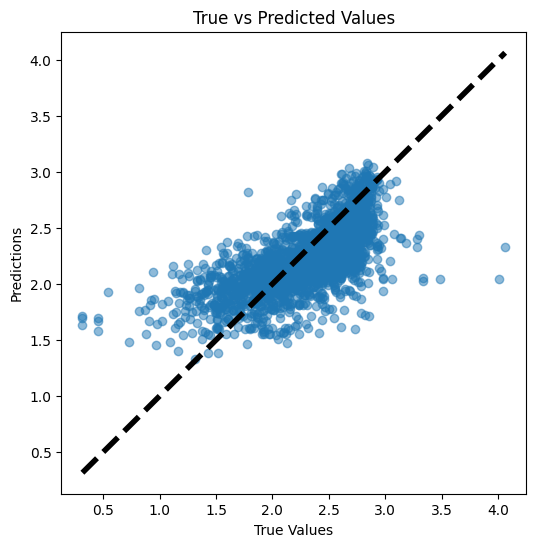

In [13]:
# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(true_labels, predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.plot([true_labels.min(), true_labels.max()], [true_labels.min(), true_labels.max()], 'k--', lw=4)
plt.show()

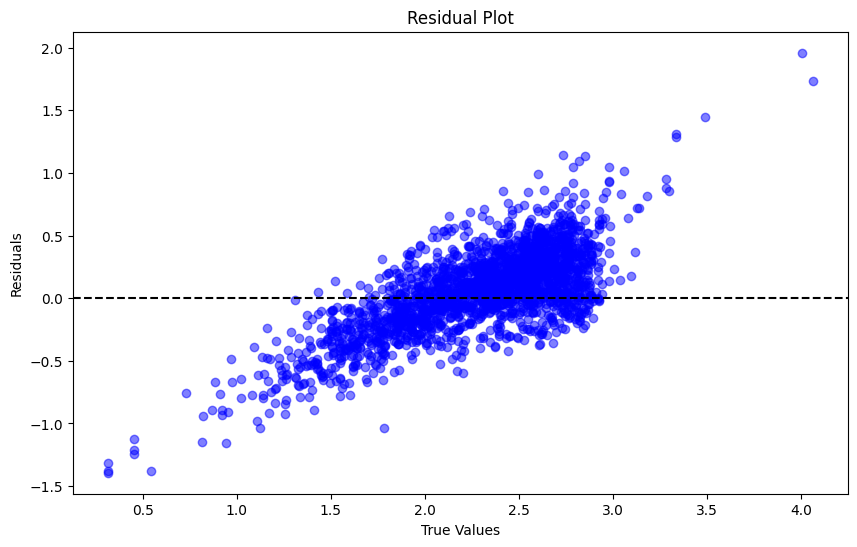

In [14]:
# Calculate residuals
residuals = [true - pred for true, pred in zip(true_labels, predictions)]

# Plotting the residual plot
plt.figure(figsize=(10, 6))
plt.scatter(true_labels, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--')  # Adds a horizontal line at zero for reference
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_23464\1017067901.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_labels, label='True Labels', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_23464\1017067901.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(predictions, label='Predictions', shade=True)


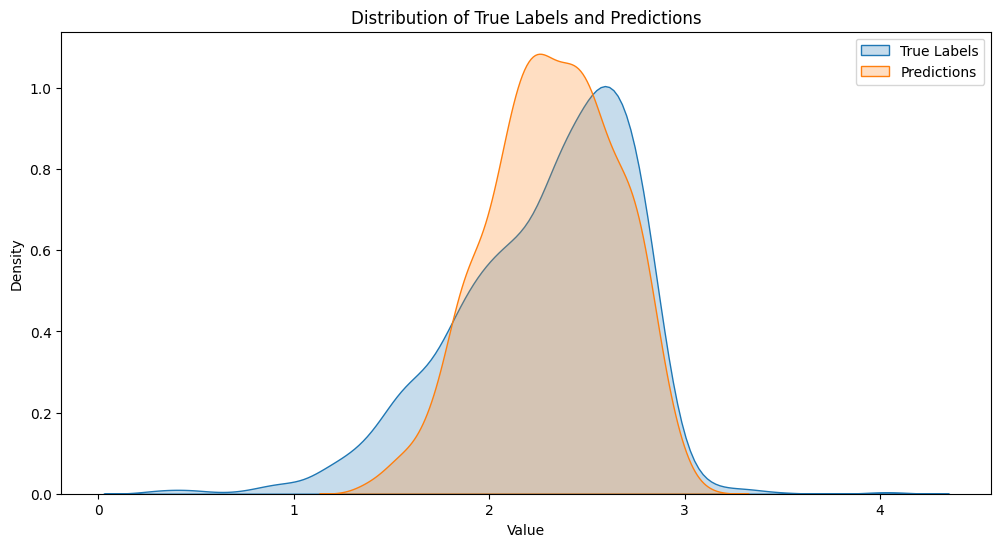

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# KDE plot of True Labels
sns.kdeplot(true_labels, label='True Labels', shade=True)

# KDE plot of Predictions
sns.kdeplot(predictions, label='Predictions', shade=True)

# Plot formatting
plt.title('Distribution of True Labels and Predictions')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

# Plotting Training distribution

In [ ]:
train_files = get_file_paths('./data/records/train')

# Collect all true labels and predictions
true_labels_training = []
with torch.no_grad():
    for train_file in train_files:
        train_loader = create_dataloader(train_file, True, 32)
        for data, labels in tqdm(train_loader):
            true_labels_training.extend(labels)

100%|██████████| 16/16 [00:00<00:00, 25.50it/s]


In [ ]:
float_list = [t.item() for t in true_labels_training]

C:\Users\lhmtr\AppData\Local\Temp\ipykernel_48180\1988724421.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_labels, label='Validation', shade=True)
C:\Users\lhmtr\AppData\Local\Temp\ipykernel_48180\1988724421.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(float_list, label='Training', shade=True)


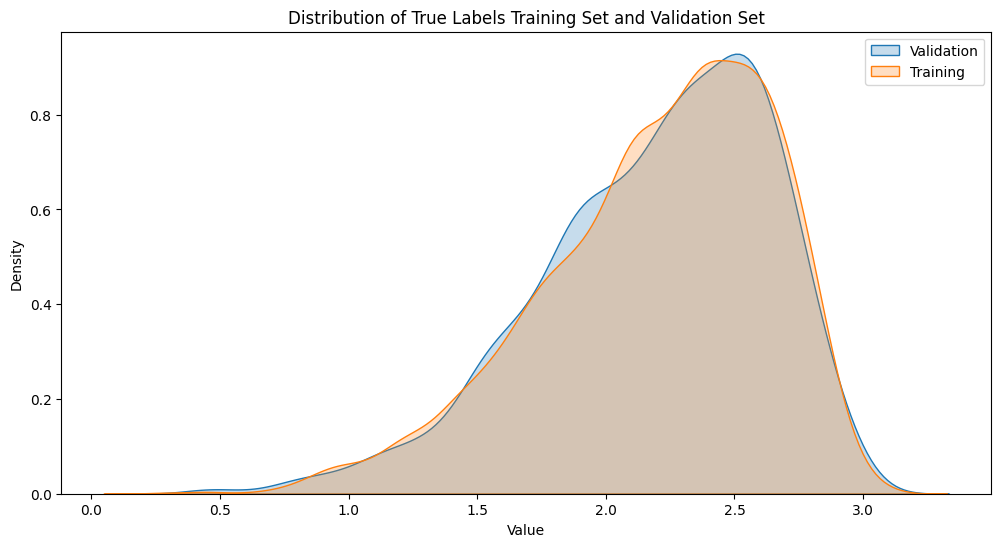

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# KDE plot of True Labels
sns.kdeplot(true_labels, label='Validation', shade=True)
# KDE plot of True Labels
sns.kdeplot(float_list, label='Training', shade=True)

# Plot formatting
plt.title('Distribution of True Labels Training Set and Validation Set')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()